# 151 Animals Classification

The purpose of this project is to classify images of 151 different animals.

The dataset can be found on kaggle at https://www.kaggle.com/sharansmenon/animals141

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.layers as kl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json
import pprint

# Data Preprocessing

In [2]:
dataPath="/Users/ericwolos/ML/archive/animals/archive/dataset/dataset"

In [3]:
batchSize = 32
imageSize = (224,224)
largeNum = 100000

In [4]:
ds = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    seed = 321,
    batch_size=batchSize,
    image_size=imageSize
)

Found 6270 files belonging to 151 classes.


In [5]:
dsSize = len(ds)

In [6]:
classNames = ds.class_names
numClasses = len(classNames)
print("There are ", numClasses, "classes  in this dataset")

There are  151 classes  in this dataset


In [7]:
tFile = open("/Users/ericwolos/ML/archive/animals/archive/translation.json",'r')
translations = json.load(tFile)
tFile.close()
pprint.PrettyPrinter().pprint(translations)

{'acinonyx-jubatus': 'Cheetah',
 'aethia-cristatella': 'Crested Auklet',
 'agalychnis-callidryas': 'Tree Frog',
 'agkistrodon-contortrix': 'Eastern Copperhead',
 'ailuropoda-melanoleuca': 'Giant Panda',
 'ailurus-fulgens': 'Red Panda',
 'alces-alces': 'Moose',
 'anas-platyrhynchos': 'Mallard',
 'ankylosaurus-magniventris': 'Ankylosaurus',
 'apis-mellifera': 'Western Honey Bee',
 'aptenodytes-forsteri': 'Emperor Penguin',
 'aquila-chrysaetos': 'Golden Eagle',
 'ara-macao': 'Scarlet Macaw',
 'architeuthis-dux': 'Giant Squid',
 'ardea-herodias': 'Great Blue Heron',
 'balaenoptera-musculus': 'Blue Whale',
 'betta-splendens': 'Siamese Fighting Fish',
 'bison-bison': 'American Bison',
 'bos-gaurus': 'Gaur',
 'bos-taurus': 'Domestic Cow',
 'bradypus-variegatus': 'Brown-throated Three-toed Sloth',
 'branta-canadensis': 'Canada Goose',
 'canis-lupus': 'Wolf',
 'canis-lupus-familiaris': 'Domestic Dog',
 'carcharodon-carcharias': 'Great White Shark',
 'cardinalis-cardinalis': 'Northern Cardinal',

Below, images will be split into training data (80%), validation data (10%), and testing data (10%)

In [8]:
ds = ds.shuffle(largeNum ,seed = 123)
train_ds = ds.take(int(dsSize*0.8))
test_ds = ds.skip(int(dsSize*0.8)).take(int(dsSize*0.1))
val_ds = ds.skip(int(dsSize*0.8)).skip(int(dsSize*0.1))

# Image Augmentation

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(height_factor=(0.15),width_factor=(.15)),
    tf.keras.layers.RandomRotation(0.2)
])

In [12]:
autotune = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(largeNum).map(lambda x, y: (augmentation(x), y), num_parallel_calls=autotune)
val_ds = val_ds.cache()
test_ds = test_ds.cache()

# Image Visualization

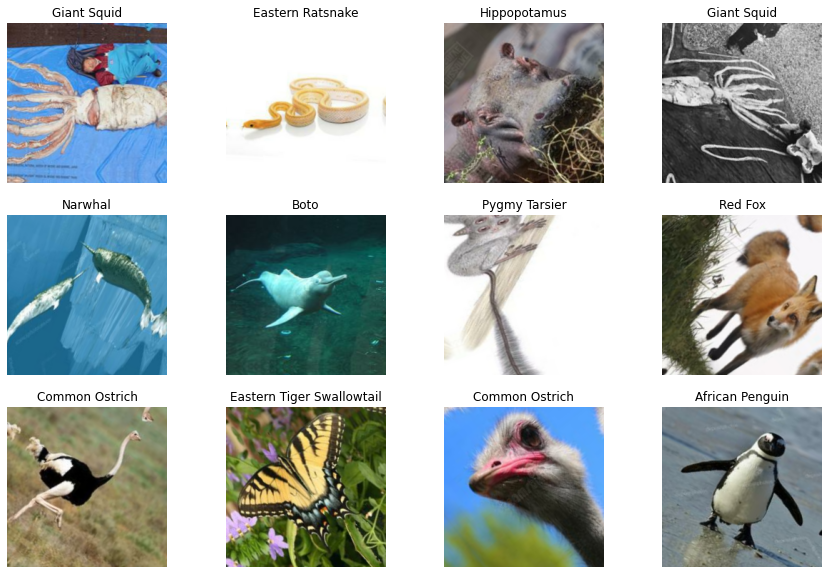

In [13]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i])
        plt.title(translations[classNames[labels[i].numpy()]])
        plt.axis("off")

# Model Construction

For this model, I have used an EfficientNetV2B1 architecture. Given the EfficientNet's effectiveness with ImageNet classification problems, I felt this problem's similarity would mean that it would be the best to use.

In [14]:
baseEffNet = tf.keras.applications.efficientnet_v2.EfficientNetV2B1(include_top=False,input_shape=(224,224,3),pooling='avg', classes = 3, weights='imagenet')

In [15]:
x = baseEffNet.output
x = kl.BatchNormalization()(x)
x = kl.Dense(128, activation='relu')(x)
x = kl.Dropout(0.3)(x)
x = kl.Dense(numClasses, activation='softmax')(x)
model = tf.keras.models.Model(baseEffNet.input, x, name='MyResNet')


In [16]:
model.summary()

Model: "MyResNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling_1[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']   

                                                                                                  
 block2c_project_bn (BatchNorma  (None, 56, 56, 32)  128         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2c_add (Add)              (None, 56, 56, 32)   0           ['block2c_project_bn[0][0]',     
                                                                  'block2b_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 28, 28, 128)  36864       ['block2c_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 28, 28, 128)  512        ['block3a_expand_conv[0][0]']    
 ization) 

                                                                                                  
 block4a_project_conv (Conv2D)  (None, 14, 14, 96)   18432       ['block4a_se_excite[0][0]']      
                                                                                                  
 block4a_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4a_project_bn[0][0]']     
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
          

 ization)                                                                                         
                                                                                                  
 block4d_expand_activation (Act  (None, 14, 14, 384)  0          ['block4d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4d_dwconv2 (DepthwiseConv  (None, 14, 14, 384)  3456       ['block4d_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 14, 14, 384)  1536       ['block4d_dwconv2[0][0]']        
 )                                                                                                
          

 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5b_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5b_se_squeeze[0][0]']     
                                                                                                  
 block5b_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5b_se_reshape[0][0]']     
                                                                                                  
 block5b_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5b_se_reduce[0][0]']      
          

 block5d_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5d_se_reduce[0][0]']      
                                                                                                  
 block5d_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5d_activation[0][0]',     
                                                                  'block5d_se_expand[0][0]']      
                                                                                                  
 block5d_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5d_se_excite[0][0]']      
                                                                                                  
 block5d_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5d_a

                                                                                                  
 block5f_add (Add)              (None, 14, 14, 112)  0           ['block5f_project_bn[0][0]',     
                                                                  'block5e_add[0][0]']            
                                                                                                  
 block6a_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block5f_add[0][0]']            
                                                                                                  
 block6a_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block6a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6a_expand_activation (Act  (None, 14, 14, 672)  0          ['block6a_expand_bn[0][0]']      
 ivation) 

 block6c_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6c_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6c_bn (BatchNormalization  (None, 7, 7, 1152)  4608        ['block6c_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6c_activation (Activation  (None, 7, 7, 1152)  0           ['block6c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6c_se_squeeze (GlobalAver  (None, 1152)        0           ['block6c_activation[0][0]']     
 agePoolin

 block6e_se_squeeze (GlobalAver  (None, 1152)        0           ['block6e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6e_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6e_se_squeeze[0][0]']     
                                                                                                  
 block6e_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block6e_se_reshape[0][0]']     
                                                                                                  
 block6e_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block6e_se_reduce[0][0]']      
                                                                                                  
 block6e_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6e_activation[0][0]',     
          

 block6g_se_excite (Multiply)   (None, 7, 7, 1152)   0           ['block6g_activation[0][0]',     
                                                                  'block6g_se_expand[0][0]']      
                                                                                                  
 block6g_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6g_se_excite[0][0]']      
                                                                                                  
 block6g_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6g_add (Add)              (None, 7, 7, 192)    0           ['block6g_project_bn[0][0]',     
                                                                  'block6f_add[0][0]']            
          

                                                                  'block6h_add[0][0]']            
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 1280)   245760      ['block6i_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 1280)   5120        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 7, 7, 1280)   0           ['top_bn[0][0]']                 
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1280)        0           ['top_activation[0][0]']         
 2D)                                                                                              
          

In [17]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

The Early Stopping used below is necessary to prevent model overfitting. It assesses changes in accuracy over each epoch.

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1, min_delta = 0.03)

# Model Training and Testing

In [19]:
history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs = 100, 
    callbacks=[callback],
)

Epoch 1/100
156/156 [==============================] - 666s 4s/step - loss: 5.1841 - accuracy: 0.0218 - val_loss: 4.7085 - val_accuracy: 0.0625
Epoch 2/100
156/156 [==============================] - 3191s 21s/step - loss: 4.0187 - accuracy: 0.1768 - val_loss: 3.7908 - val_accuracy: 0.2932
Epoch 3/100
156/156 [==============================] - 1647s 11s/step - loss: 2.9570 - accuracy: 0.3886 - val_loss: 2.8090 - val_accuracy: 0.4479
Epoch 4/100
156/156 [==============================] - 1642s 11s/step - loss: 2.1209 - accuracy: 0.5643 - val_loss: 1.6494 - val_accuracy: 0.6860
Epoch 5/100
156/156 [==============================] - 1644s 11s/step - loss: 1.5336 - accuracy: 0.6812 - val_loss: 0.9481 - val_accuracy: 0.8229
Epoch 6/100
156/156 [==============================] - 1650s 11s/step - loss: 1.1242 - accuracy: 0.7633 - val_loss: 2.0425 - val_accuracy: 0.5774
Epoch 7/100
156/156 [==============================] - 1640s 11s/step - loss: 0.8307 - accuracy: 0.8230 - val_loss: 2.2163 - v

In [20]:
testLoss, testAccuracy = model.evaluate(test_ds)

19/19 [==============================] - 47s 2s/step - loss: 0.4630 - accuracy: 0.9030


In [21]:
print("This model is {}% acccurate on the test dataset.".format(round(testAccuracy*100, 2)))

This model is 90.3% acccurate on the test dataset.


# Image Visualization with Model Predictions

In [22]:
for testImages, imageLabels in test_ds.take(1):
    testImages = testImages.numpy()
    imageLabels = imageLabels.numpy()
    predictions = model.predict(testImages)

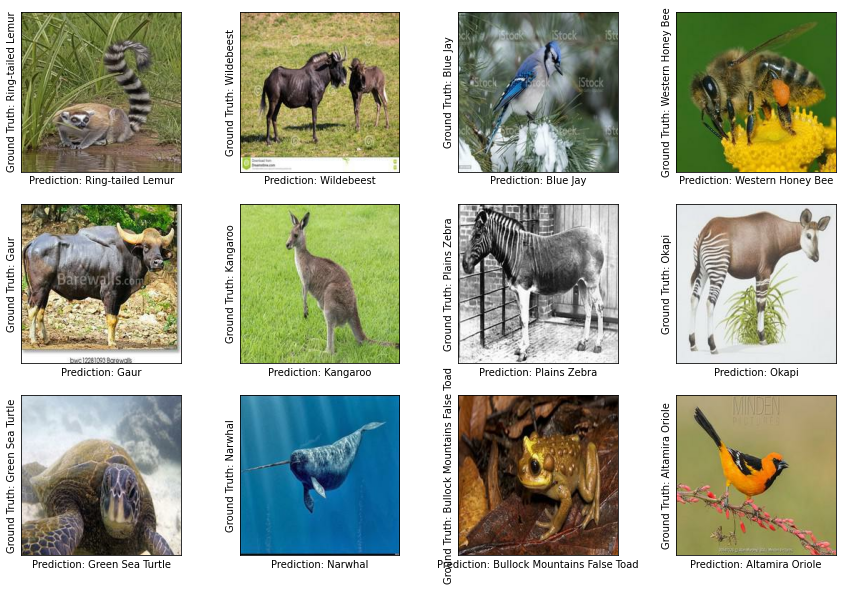

In [23]:
plt.figure(figsize = (15,10))
numImages = 12    
for imageNum in range(numImages):
    ax = plt.subplot(3, 4, imageNum + 1)
    plt.imshow(testImages[imageNum])
    plt.xlabel("Prediction: " + str(translations[classNames[np.argmax(predictions[imageNum])]]), fontsize = 10)
    plt.ylabel("Ground Truth: " + str(translations[classNames[imageLabels[imageNum]]]), fontsize = 10)
    plt.xticks([])
    plt.yticks([])

plt.show()